In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
from model import ode_y, ode_y_jump_approach_two
from numba import njit
from utilities import find_nearest_value

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
def simulation(y_grid, e_grid, h_grid, g_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ht = np.zeros(T+1)
    gt = np.zeros((len(g_grid), T+1))
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ht[i] = np.interp(y_start, y_grid, h_grid)
        for n in range(gt.shape[0]):
            gt[n, i] = np.interp(y_start, y_grid, g_grid[n])
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ht, gt

In [3]:
def make_plots(ξ_1m, ξ_2m, ξ_a, et_tilde_baseline, emission_path, density_path, make_plot=True):
    η = .032
    δ = .01

    θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
    πc_o = np.ones_like(θ)/len(θ)
    σ_y = 1.2*1.86/1000

    y_bar = 2.
    γ_1 = 1.7675/10000
    γ_2 = .0022*2
    γ_2p = np.array([0, .0197*2])
    πd_o = np.array([.5, .5])

    n_y = 100
    y_grid_long = np.linspace(1e-10, 10, n_y)
    y_grid_short = np.linspace(1e-10, 2, n_y)

    # Prepare ϕ_i
    ϕ_list = []
    for γ_2p_i in γ_2p:
        model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
        model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                           tol=1e-8, max_iter=5_000, print_all=False)
        ϕ_list.append(model_res['v0'])

    ϕ_list_short = []
    for ϕ_i in ϕ_list:
        temp = np.interp(y_grid_short, y_grid_long, ϕ_i)
        ϕ_list_short.append(temp)
    ϕ_i = np.array(ϕ_list_short)

    # Compute ϕ
    ς = .1
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
    model_res = \
              ode_y_jump_approach_two(y_grid_short, model_paras, v0=np.average(ϕ_i, axis=0, weights=πd_o),
                                      ϵ=.5, tol=1e-8, max_iter=10_000, print_all=False)
    
    h = 1./ξ_1m * (-model_res['v0_dy'] + (1-η)*model_res['d_Λ']) * model_res['e_tilde'] * σ_y
    
    # Simulate e_tilde
    et_tilde, yt, ht, gt = simulation(y_grid_short, model_res['e_tilde'], h, model_res['g'], θ=1.86/1000., y_start=.5394, T=80)
    
    
    if not make_plot:
        return et_tilde
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
        # Plot e_tilde and damage probability
        ax1.plot(et_tilde, color='C3', label='distorted', linewidth=2.)
        ax1.plot(et_tilde_baseline, color='C0', label=r'baseline', linewidth=2.)
        ax1.set_xlabel('Years', fontsize=13)
        ax1.set_ylabel(r'$\tilde{e}$', fontsize=13)
        ax1.legend(frameon=False)
        ax1.set_ylim(0., 14.)
        
        ax2.plot(gt[0]*.5, color='C3', label='low damage', linewidth=2.)
        ax2.plot(gt[1]*.5, color='C0', label='high damage', linewidth=2.)
        ax2.set_xlabel('Years', fontsize=13)
        ax2.set_ylabel('Distorted probability for damage function', fontsize=13)
        ax2.legend(frameon=False)
        ax2.set_ylim(-.01, 1.01)
        
        fig.savefig(emission_path)

        # Plot density
        loc_10 = find_nearest_value(y_grid_short, yt[10])
        loc_40 = find_nearest_value(y_grid_short, yt[40])
        loc_80 = find_nearest_value(y_grid_short, yt[80])
        
        bins = np.linspace(1, 3.5, 14)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
        ax1.hist(θ*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
        ax1.hist((θ+σ_y*ht[10])*1000, weights=model_res['πc'][:, loc_10], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
        ax1.set_xlabel('Climate Sensitivity, Year 10')
        ax1.set_ylabel('Density')
        ax1.set_xlim(.8, 3.5)

        ax2.hist(θ*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
        ax2.hist((θ+σ_y*ht[40])*1000, weights=model_res['πc'][:, loc_40], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
        ax2.set_xlabel('Climate Sensitivity, Year 40')
        ax2.set_ylabel('Density')
        ax2.set_xlim(.8, 3.5)

        ax3.hist(θ*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
        ax3.hist((θ+σ_y*ht[80])*1000, weights=model_res['πc'][:, loc_80], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
        ax3.set_xlabel('Climate Sensitivity, Year 80')
        ax3.set_ylabel('Density')
        ax3.set_xlim(.8, 3.5)
        print(np.mean(np.abs((model_res['πc'][:, loc_80]-model_res['πc'][:, loc_10]))))

        fig.savefig(density_path)

In [4]:
e_tilde_baseline = make_plots(1000., 1000., 1000., None, None, None, False)

Converged. Total iteration 2215: LHS Error: 9.959568756517934e-09; RHS Error 2.6318500072685736e-06
Converged. Total iteration 2016: LHS Error: 9.992958738269664e-09; RHS Error 8.448167798956626e-06
Converged. Total iteration 275: LHS Error: 9.810616180550014e-09; RHS Error 4.384237247911926e-06


Converged. Total iteration 2207: LHS Error: 9.991167500972287e-09; RHS Error 2.4379591590966473e-06
Converged. Total iteration 2037: LHS Error: 9.982724175072732e-09; RHS Error 7.56827625155354e-06
Converged. Total iteration 264: LHS Error: 9.909212506098442e-09; RHS Error 5.364301029417429e-06
2.3559638759560833e-12
Converged. Total iteration 2206: LHS Error: 9.995641904458896e-09; RHS Error 2.6995738503270616e-06
Converged. Total iteration 2035: LHS Error: 9.976443338111096e-09; RHS Error 8.560574775275998e-06
Converged. Total iteration 269: LHS Error: 9.47121273076057e-09; RHS Error 4.556363355778803e-06
1.2780369140425555e-06
Converged. Total iteration 2215: LHS Error: 9.959568756517934e-09; RHS Error 2.6318500072685736e-06
Converged. Total iteration 2016: LHS Error: 9.992958738269664e-09; RHS Error 8.448167798956626e-06
Converged. Total iteration 435: LHS Error: 9.994164884563617e-09; RHS Error 8.59940452717367e-06
2.9317759760210917e-13


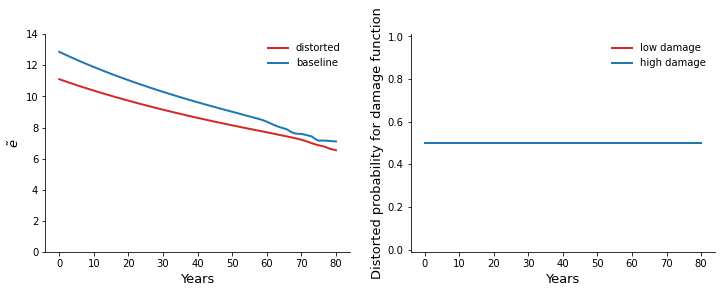

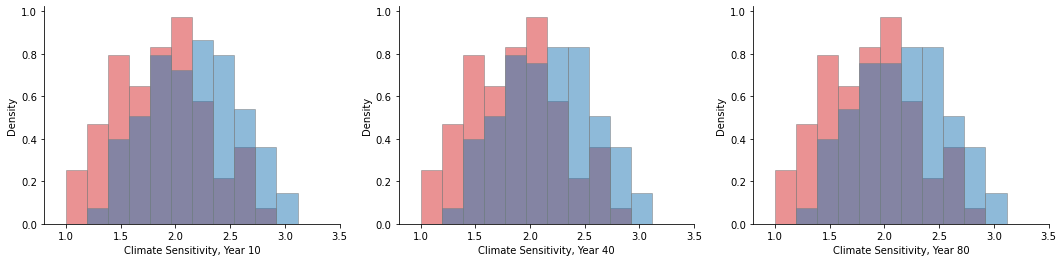

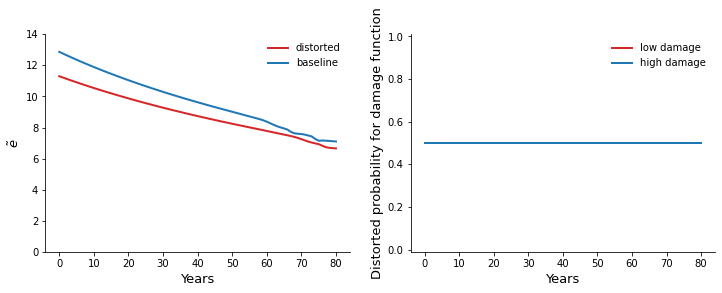

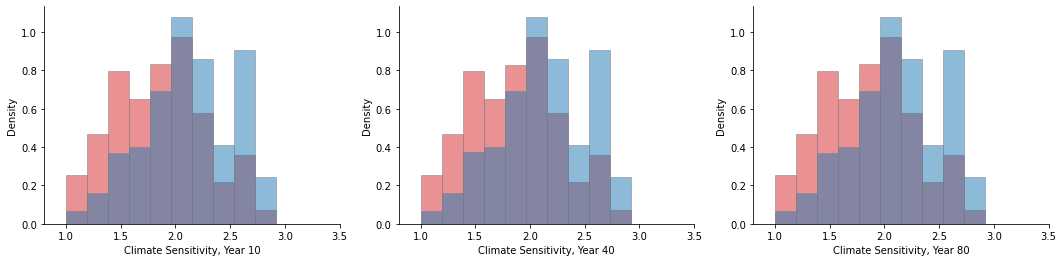

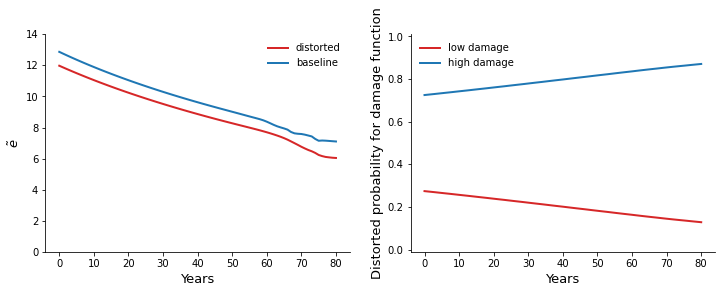

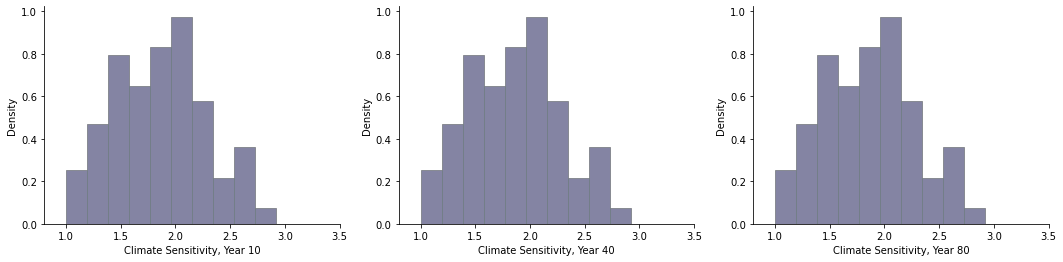

In [5]:
# h
make_plots(1./400, 1000., 1000., e_tilde_baseline, '../plots/decomposition/e_h.pdf', '../plots/decomposition/density_h.pdf', True)
# ambiguity
make_plots(1000., 1000., 1./10000, e_tilde_baseline, '../plots/decomposition/e_a.pdf', '../plots/decomposition/density_a.pdf', True)
# damage uncertainty
make_plots(1000., 1./80, 1000., e_tilde_baseline, '../plots/decomposition/e_d.pdf', '../plots/decomposition/density_d.pdf', True)

Converged. Total iteration 2200: LHS Error: 9.981955177360002e-09; RHS Error 2.5050304861162125e-06
Converged. Total iteration 2050: LHS Error: 9.991184907187645e-09; RHS Error 7.781912741127632e-06
Converged. Total iteration 260: LHS Error: 9.217297938790558e-09; RHS Error 4.56268488004119e-06
1.9886196874233654e-05
Converged. Total iteration 2207: LHS Error: 9.991167500972287e-09; RHS Error 2.4379591590966473e-06
Converged. Total iteration 2037: LHS Error: 9.982724175072732e-09; RHS Error 7.56827625155354e-06
Converged. Total iteration 341: LHS Error: 9.673551071287534e-09; RHS Error 6.327421485027851e-06
3.3970128985995173e-12
Converged. Total iteration 2206: LHS Error: 9.995641904458896e-09; RHS Error 2.6995738503270616e-06
Converged. Total iteration 2035: LHS Error: 9.976443338111096e-09; RHS Error 8.560574775275998e-06
Converged. Total iteration 545: LHS Error: 9.723917532289406e-09; RHS Error 8.200338867433987e-06
4.221698786117079e-05


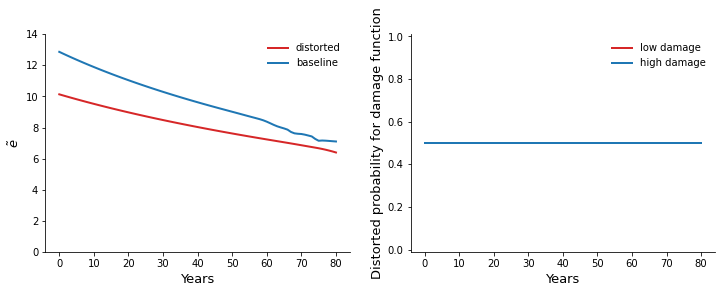

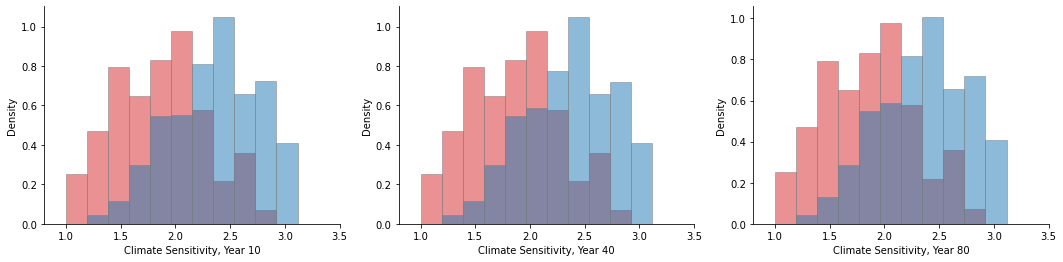

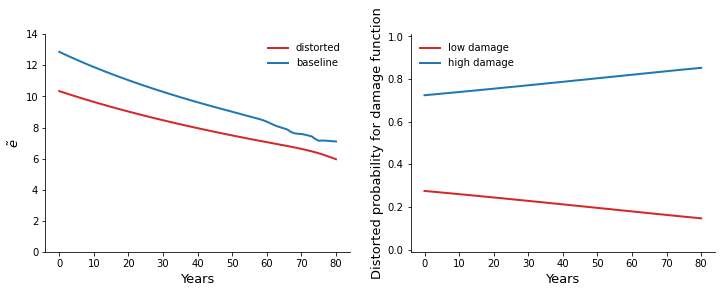

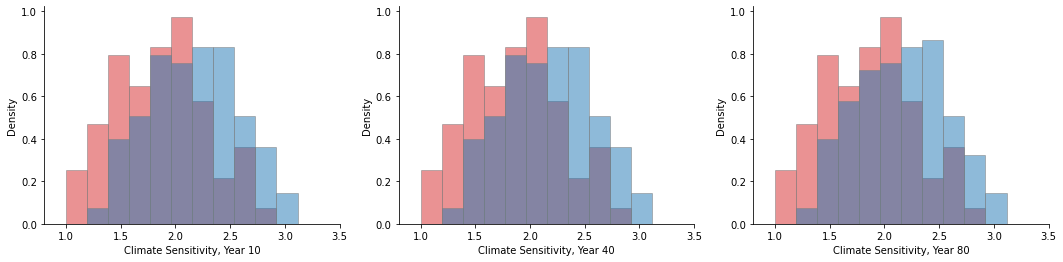

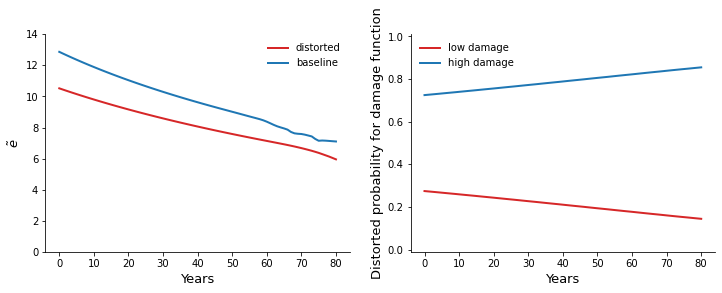

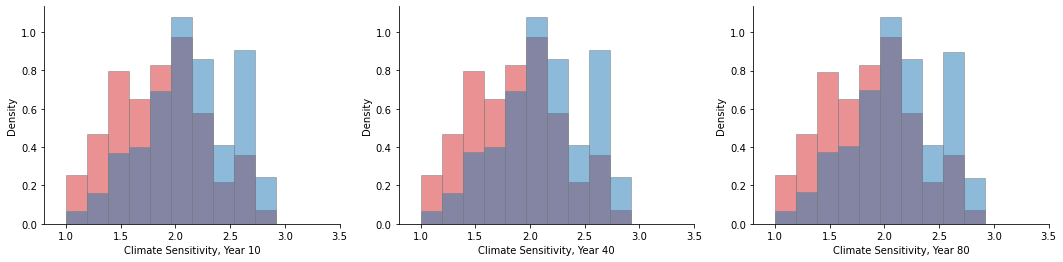

In [6]:
# h + ambiguity
make_plots(1./400, 1000., 1./10000., e_tilde_baseline, '../plots/decomposition/e_ha.pdf', '../plots/decomposition/density_ha.pdf', True)
# h + damage
make_plots(1./400, 1./80, 1000., e_tilde_baseline, '../plots/decomposition/e_hd.pdf', '../plots/decomposition/density_hd.pdf', True)
# ambiguity + damage
make_plots(1000., 1./80, 1./10000, e_tilde_baseline, '../plots/decomposition/e_ad.pdf', '../plots/decomposition/density_ad.pdf', True)